In [2]:
# Shrirang Alias Samarth Patil
# 19BAI10079

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


    16384/182082353 [..............................] - ETA: 0s


  4202496/182082353 [..............................] - ETA: 9s


  8396800/182082353 [>.............................] - ETA: 30s


 23764992/182082353 [==>...........................] - ETA: 10s


 41656320/182082353 [=====>........................] - ETA: 5s 


 41951232/182082353 [=====>........................] - ETA: 8s


 59785216/182082353 [========>.....................] - ETA: 5s


 75505664/182082353 [===========>..................] - ETA: 5s


 92192768/182082353 [==============>...............] - ETA: 4s


109060096/182082353 [================>.............] - ETA: 2s


114999296/182082353 [=================>............] - ETA: 2s


117448704/182082353 [==================>...........] - ETA: 2s


125837312/182082353 [===================>..........] - ETA: 2s


141508608/182082353 [======================>.......] - ETA: 1s


159391744/182082353 [=========================>....] - ETA: 0s


175284224/182082353 [===========================>..] - ETA: 0s


182083584/182082353 [==============================] - 6s 0us/step



182091776/182082353 [==============================] - 6s 0us/step


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['yes' 'go' 'left' 'right' 'up' 'down' 'stop' 'no']


In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/up/05739450_nohash_2.wav', shape=(), dtype=string)


In [6]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [7]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

In [8]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [9]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

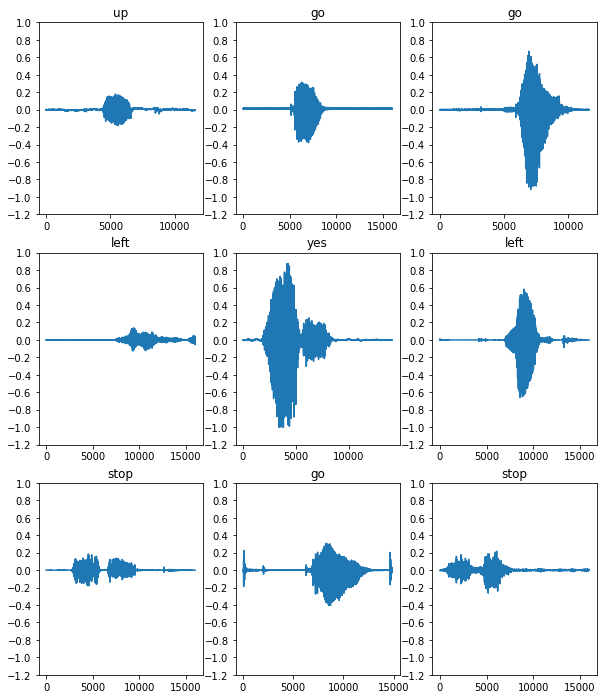

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [13]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: up
Waveform shape: (11606,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

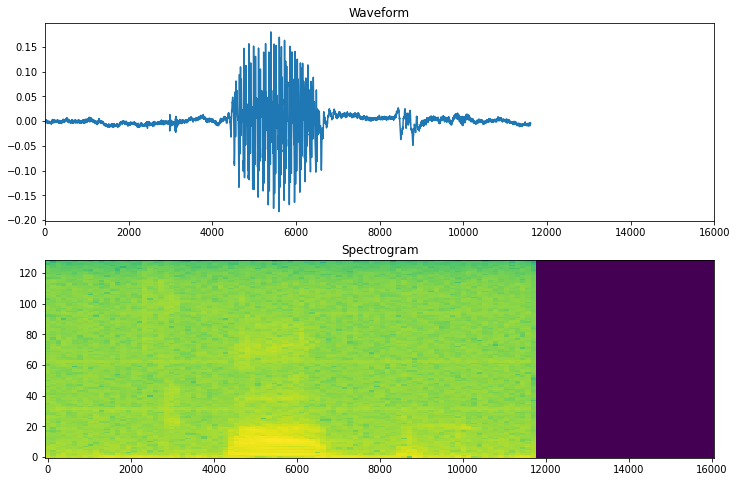

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [18]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

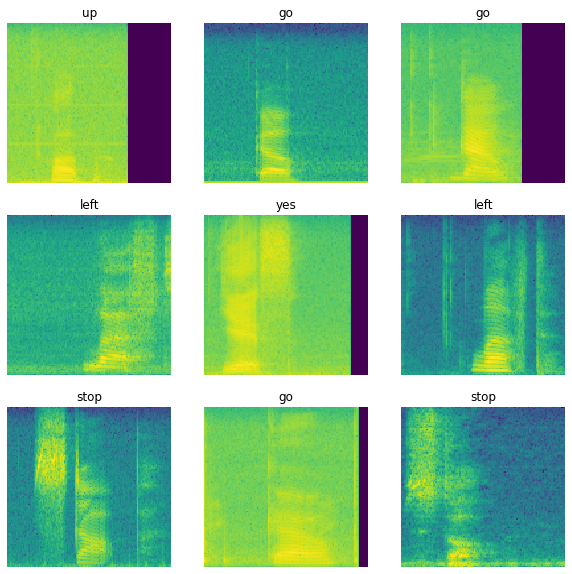

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [20]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [21]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [22]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [23]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [24]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [26]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10



  1/100 [..............................] - ETA: 14:33 - loss: 2.1404 - accuracy: 0.1250


  6/100 [>.............................] - ETA: 1s - loss: 2.1343 - accuracy: 0.1901   


  8/100 [=>............................] - ETA: 1s - loss: 2.1179 - accuracy: 0.1992


 10/100 [==>...........................] - ETA: 2s - loss: 2.1113 - accuracy: 0.1937


 12/100 [==>...........................] - ETA: 2s - loss: 2.0966 - accuracy: 0.1927


 14/100 [===>..........................] - ETA: 2s - loss: 2.0810 - accuracy: 0.2054


 15/100 [===>..........................] - ETA: 2s - loss: 2.0767 - accuracy: 0.2073


 17/100 [====>.........................] - ETA: 2s - loss: 2.0698 - accuracy: 0.2142


 19/100 [====>.........................] - ETA: 2s - loss: 2.0623 - accuracy: 0.2196


 21/100 [=====>........................] - ETA: 2s - loss: 2.0495 - accuracy: 0.2321


 23/100 [=====>........................] - ETA: 2s - loss: 2.0419 - accuracy: 0.2357


 25/100 [======>.......................] - ETA: 2s - loss: 2.0272 - accuracy: 0.2419


 27/100 [=======>......................] - ETA: 2s - loss: 2.0233 - accuracy: 0.2436


 29/100 [=======>......................] - ETA: 2s - loss: 2.0171 - accuracy: 0.2462


 31/100 [========>.....................] - ETA: 2s - loss: 2.0041 - accuracy: 0.2515


 33/100 [========>.....................] - ETA: 2s - loss: 1.9962 - accuracy: 0.2576


 35/100 [=========>....................] - ETA: 2s - loss: 1.9887 - accuracy: 0.2647


 37/100 [==========>...................] - ETA: 2s - loss: 1.9786 - accuracy: 0.2741


 39/100 [==========>...................] - ETA: 1s - loss: 1.9715 - accuracy: 0.2784


 41/100 [===========>..................] - ETA: 1s - loss: 1.9690 - accuracy: 0.2839


 43/100 [===========>..................] - ETA: 1s - loss: 1.9624 - accuracy: 0.2878


 45/100 [============>.................] - ETA: 1s - loss: 1.9536 - accuracy: 0.2944


 47/100 [=============>................] - ETA: 1s - loss: 1.9427 - accuracy: 0.2992


 49/100 [=============>................] - ETA: 1s - loss: 1.9336 - accuracy: 0.3048


 51/100 [==============>...............] - ETA: 1s - loss: 1.9228 - accuracy: 0.3110


 53/100 [==============>...............] - ETA: 1s - loss: 1.9120 - accuracy: 0.3166


 55/100 [===============>..............] - ETA: 1s - loss: 1.9018 - accuracy: 0.3205


 57/100 [================>.............] - ETA: 1s - loss: 1.8941 - accuracy: 0.3229


 59/100 [================>.............] - ETA: 1s - loss: 1.8847 - accuracy: 0.3257


 61/100 [=================>............] - ETA: 1s - loss: 1.8780 - accuracy: 0.3286


 63/100 [=================>............] - ETA: 1s - loss: 1.8690 - accuracy: 0.3318


 65/100 [==================>...........] - ETA: 1s - loss: 1.8604 - accuracy: 0.3351


 67/100 [===================>..........] - ETA: 1s - loss: 1.8499 - accuracy: 0.3403


 69/100 [===================>..........] - ETA: 1s - loss: 1.8427 - accuracy: 0.3438


 71/100 [====================>.........] - ETA: 0s - loss: 1.8361 - accuracy: 0.3473


 73/100 [====================>.........] - ETA: 0s - loss: 1.8288 - accuracy: 0.3495


 75/100 [=====================>........] - ETA: 0s - loss: 1.8222 - accuracy: 0.3506


 77/100 [======================>.......] - ETA: 0s - loss: 1.8182 - accuracy: 0.3543


 79/100 [======================>.......] - ETA: 0s - loss: 1.8135 - accuracy: 0.3564


 81/100 [=======================>......] - ETA: 0s - loss: 1.8095 - accuracy: 0.3580


 83/100 [=======================>......] - ETA: 0s - loss: 1.8031 - accuracy: 0.3607


 85/100 [========================>.....] - ETA: 0s - loss: 1.7959 - accuracy: 0.3631


 87/100 [=========================>....] - ETA: 0s - loss: 1.7900 - accuracy: 0.3648


 89/100 [=========================>....] - ETA: 0s - loss: 1.7809 - accuracy: 0.3675


 91/100 [==========================>...] - ETA: 0s - loss: 1.7723 - accuracy: 0.3705


 93/100 [==========================>...] - ETA: 0s - loss: 1.7661 - accuracy: 0.3725


 95/100 [===========================>..] - ETA: 0s - loss: 1.7609 - accuracy: 0.3743


 97/100 [============================>.] - ETA: 0s - loss: 1.7526 - accuracy: 0.3779


 99/100 [============================>.] - ETA: 0s - loss: 1.7440 - accuracy: 0.3807


100/100 [==============================] - 13s 40ms/step - loss: 1.7404 - accuracy: 0.3823 - val_loss: 1.3372 - val_accuracy: 0.5550


Epoch 2/10

  1/100 [..............................] - ETA: 0s - loss: 1.1268 - accuracy: 0.6875


 15/100 [===>..........................] - ETA: 0s - loss: 1.2974 - accuracy: 0.5458


 29/100 [=======>......................] - ETA: 0s - loss: 1.3101 - accuracy: 0.5339


 43/100 [===========>..................] - ETA: 0s - loss: 1.2940 - accuracy: 0.5498


 57/100 [================>.............] - ETA: 0s - loss: 1.2547 - accuracy: 0.5652


 72/100 [====================>.........] - ETA: 0s - loss: 1.2253 - accuracy: 0.5768


 87/100 [=========================>....] - ETA: 0s - loss: 1.2076 - accuracy: 0.5815


100/100 [==============================] - 0s 4ms/step - loss: 1.1776 - accuracy: 0.5903 - val_loss: 0.9747 - val_accuracy: 0.6600


Epoch 3/10

  1/100 [..............................] - ETA: 0s - loss: 1.1649 - accuracy: 0.5469


 16/100 [===>..........................] - ETA: 0s - loss: 1.0164 - accuracy: 0.6416


 30/100 [========>.....................] - ETA: 0s - loss: 0.9941 - accuracy: 0.6547


 45/100 [============>.................] - ETA: 0s - loss: 0.9593 - accuracy: 0.6618


 60/100 [=================>............] - ETA: 0s - loss: 0.9433 - accuracy: 0.6674


 75/100 [=====================>........] - ETA: 0s - loss: 0.9251 - accuracy: 0.6717


 90/100 [==========================>...] - ETA: 0s - loss: 0.9121 - accuracy: 0.6750


100/100 [==============================] - 0s 4ms/step - loss: 0.9027 - accuracy: 0.6778 - val_loss: 0.8096 - val_accuracy: 0.7150


Epoch 4/10

  1/100 [..............................] - ETA: 0s - loss: 0.9141 - accuracy: 0.6562


 16/100 [===>..........................] - ETA: 0s - loss: 0.8000 - accuracy: 0.7207


 31/100 [========>.....................] - ETA: 0s - loss: 0.7972 - accuracy: 0.7293


 46/100 [============>.................] - ETA: 0s - loss: 0.7949 - accuracy: 0.7272


 61/100 [=================>............] - ETA: 0s - loss: 0.7848 - accuracy: 0.7310


 76/100 [=====================>........] - ETA: 0s - loss: 0.7788 - accuracy: 0.7307


 91/100 [==========================>...] - ETA: 0s - loss: 0.7699 - accuracy: 0.7309


100/100 [==============================] - 0s 4ms/step - loss: 0.7647 - accuracy: 0.7316 - val_loss: 0.7325 - val_accuracy: 0.7625


Epoch 5/10

  1/100 [..............................] - ETA: 0s - loss: 0.7072 - accuracy: 0.7500


 15/100 [===>..........................] - ETA: 0s - loss: 0.6937 - accuracy: 0.7260


 29/100 [=======>......................] - ETA: 0s - loss: 0.6918 - accuracy: 0.7387


 44/100 [============>.................] - ETA: 0s - loss: 0.6841 - accuracy: 0.7479


 58/100 [================>.............] - ETA: 0s - loss: 0.6670 - accuracy: 0.7557


 73/100 [====================>.........] - ETA: 0s - loss: 0.6636 - accuracy: 0.7592


 88/100 [=========================>....] - ETA: 0s - loss: 0.6573 - accuracy: 0.7630


100/100 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.7658 - val_loss: 0.6697 - val_accuracy: 0.7688


Epoch 6/10

  1/100 [..............................] - ETA: 0s - loss: 0.7840 - accuracy: 0.7188


 16/100 [===>..........................] - ETA: 0s - loss: 0.5931 - accuracy: 0.7832


 31/100 [========>.....................] - ETA: 0s - loss: 0.5961 - accuracy: 0.7878


 44/100 [============>.................] - ETA: 0s - loss: 0.5999 - accuracy: 0.7855


 57/100 [================>.............] - ETA: 0s - loss: 0.6014 - accuracy: 0.7870


 71/100 [====================>.........] - ETA: 0s - loss: 0.5952 - accuracy: 0.7887


 84/100 [========================>.....] - ETA: 0s - loss: 0.5914 - accuracy: 0.7883


 98/100 [============================>.] - ETA: 0s - loss: 0.5800 - accuracy: 0.7930


100/100 [==============================] - 0s 5ms/step - loss: 0.5796 - accuracy: 0.7937 - val_loss: 0.6108 - val_accuracy: 0.7875


Epoch 7/10

  1/100 [..............................] - ETA: 0s - loss: 0.6092 - accuracy: 0.7812


 15/100 [===>..........................] - ETA: 0s - loss: 0.5441 - accuracy: 0.8135


 30/100 [========>.....................] - ETA: 0s - loss: 0.5585 - accuracy: 0.8016


 44/100 [============>.................] - ETA: 0s - loss: 0.5485 - accuracy: 0.8050


 58/100 [================>.............] - ETA: 0s - loss: 0.5405 - accuracy: 0.8082


 73/100 [====================>.........] - ETA: 0s - loss: 0.5382 - accuracy: 0.8095


 87/100 [=========================>....] - ETA: 0s - loss: 0.5363 - accuracy: 0.8089


100/100 [==============================] - 0s 4ms/step - loss: 0.5261 - accuracy: 0.8117 - val_loss: 0.5708 - val_accuracy: 0.8087


Epoch 8/10

  1/100 [..............................] - ETA: 0s - loss: 0.5134 - accuracy: 0.7969


 16/100 [===>..........................] - ETA: 0s - loss: 0.4792 - accuracy: 0.8271


 31/100 [========>.....................] - ETA: 0s - loss: 0.4833 - accuracy: 0.8281


 46/100 [============>.................] - ETA: 0s - loss: 0.4789 - accuracy: 0.8315


 61/100 [=================>............] - ETA: 0s - loss: 0.4766 - accuracy: 0.8302


 76/100 [=====================>........] - ETA: 0s - loss: 0.4742 - accuracy: 0.8312


 91/100 [==========================>...] - ETA: 0s - loss: 0.4742 - accuracy: 0.8269


100/100 [==============================] - 0s 4ms/step - loss: 0.4747 - accuracy: 0.8267 - val_loss: 0.5429 - val_accuracy: 0.8163


Epoch 9/10

  1/100 [..............................] - ETA: 0s - loss: 0.5391 - accuracy: 0.8281


 16/100 [===>..........................] - ETA: 0s - loss: 0.4647 - accuracy: 0.8193


 31/100 [========>.....................] - ETA: 0s - loss: 0.4664 - accuracy: 0.8301


 46/100 [============>.................] - ETA: 0s - loss: 0.4597 - accuracy: 0.8370


 61/100 [=================>............] - ETA: 0s - loss: 0.4597 - accuracy: 0.8371


 76/100 [=====================>........] - ETA: 0s - loss: 0.4503 - accuracy: 0.8398


 92/100 [==========================>...] - ETA: 0s - loss: 0.4465 - accuracy: 0.8434


100/100 [==============================] - 0s 4ms/step - loss: 0.4427 - accuracy: 0.8428 - val_loss: 0.5379 - val_accuracy: 0.8175


Epoch 10/10

  1/100 [..............................] - ETA: 0s - loss: 0.5966 - accuracy: 0.8125


 16/100 [===>..........................] - ETA: 0s - loss: 0.4112 - accuracy: 0.8584


 31/100 [========>.....................] - ETA: 0s - loss: 0.4097 - accuracy: 0.8619


 47/100 [=============>................] - ETA: 0s - loss: 0.4055 - accuracy: 0.8660


 62/100 [=================>............] - ETA: 0s - loss: 0.4027 - accuracy: 0.8621


 78/100 [======================>.......] - ETA: 0s - loss: 0.3966 - accuracy: 0.8640


 93/100 [==========================>...] - ETA: 0s - loss: 0.3961 - accuracy: 0.8629


100/100 [==============================] - 0s 4ms/step - loss: 0.3927 - accuracy: 0.8637 - val_loss: 0.5320 - val_accuracy: 0.8213


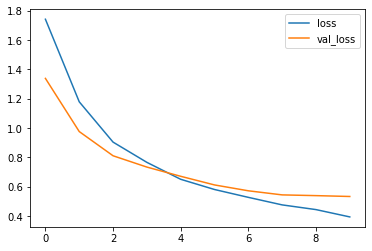

In [27]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [28]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [29]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


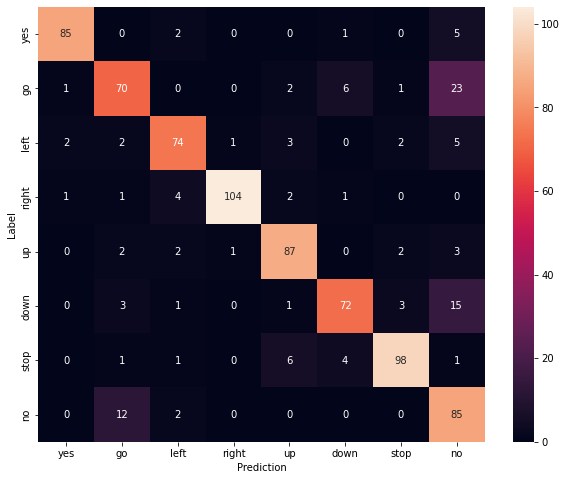

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

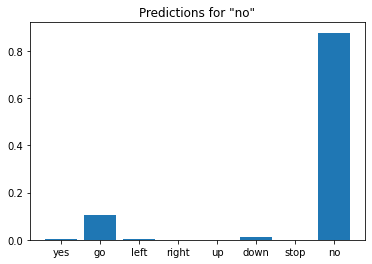

In [31]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()